In [ ]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
from random import seed
from random import randint
import math
from cvxopt import matrix, solvers
solvers.options['show_progress'] = True
import itertools
import time
import sys
import cvxpy as cp
import numpy as np

In [ ]:
def dp(t,ul):
    if t==T-1:
        return 0
    if (t, ul) in mem:
        return mem[(t, ul)][0]

    else:
        x = math.inf
        nxt=-1
        if ul==1:
            state=upper_bound[t]
        else:
            state=lower_bound[t]

        min_factor=-1
        max_factor=math.inf
        for tp in range(t+1,T):
            for u_l in [0,1]:
                allowed=1
                sp=prices_prefix_sum[tp]-prices_prefix_sum[t]
                if u_l==1:
                    DE=upper_bound[tp]-state
                else:
                    DE=lower_bound[tp]-state

                if DE/sp>max_factor+eps or DE/sp<min_factor-eps:
                    allowed=0

                if u_l==0:
                    min_factor=max(DE/sp,min_factor)
                else:
                    max_factor=min(DE/sp,max_factor)

                if allowed==0:
                    continue
                else:
                    val = dp(tp,u_l)+DE**2/sp
                    if x>=val:
                        x=val
                        nxt=(tp,u_l)

    mem[(t, ul)]=(x,nxt)
    return x


inaccurate solution found:abs(dp_cost/qp_cost-1)= 1.351517382430778e-05
T= 57
average dp time= 0.003499905268351237
average qp time= 0.019171714782714844
dp time std= 0.0
qp time std= 0.0
T= 86
average dp time= 0.025444587071736652
average qp time= 0.03476341565450033
dp time std= 0.004061481599840301
qp time std= 0.01232529588207596
inaccurate solution found:abs(dp_cost/qp_cost-1)= 1.9600201389247118e-05
T= 129
average dp time= 0.03342350323994955
average qp time= 0.016106923421223957
dp time std= 0.0
qp time std= 0.0
T= 194
average dp time= 0.17272408803304037
average qp time= 0.19797404607137045
dp time std= 0.005326225010815051
qp time std= 0.06558337465822131
inaccurate solution found:abs(dp_cost/qp_cost-1)= 2.0604226256049074e-05
T= 291
average dp time= 0.10322848955790202
average qp time= 0.201550563176473
dp time std= 0.0
qp time std= 0.0
T= 437
average dp time= 0.6904411315917969
average qp time= 1.9657214482625325
dp time std= 0.1300113944237822
qp time std= 0.463078303776777

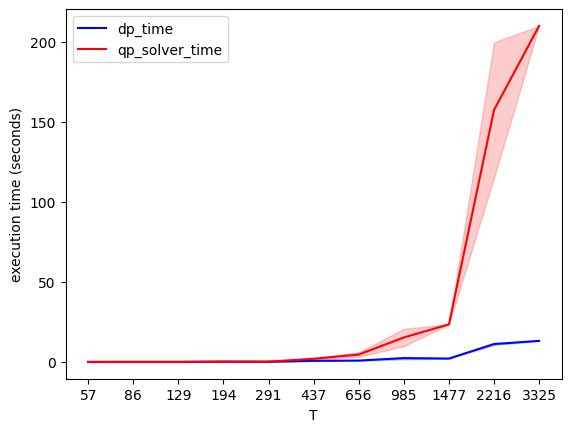

T= 57
average dp time= 0.021830956141153973
average qp time= 0.02466408411661784
dp time std= 0.003264609298510553
qp time std= 0.025752741836857374
T= 86
average dp time= 0.04366310437520345
average qp time= 0.009175300598144531
dp time std= 0.001217384040846442
qp time std= 0.0009111427951332769
T= 129
average dp time= 0.09654378890991211
average qp time= 0.01494757334391276
dp time std= 0.004548633456495394
qp time std= 0.0008381832104252134
T= 194
average dp time= 0.1763919989267985
average qp time= 0.029971599578857422
dp time std= 0.008021651626106668
qp time std= 0.0013046320999685617
T= 291
average dp time= 0.302722692489624
average qp time= 0.08198046684265137
dp time std= 0.0012788450035287114
qp time std= 0.006506428410443904
T= 437
average dp time= 1.000780423482259
average qp time= 0.3203710714975993
dp time std= 0.26604914323518397
qp time std= 0.09276498114377876
T= 656
average dp time= 1.3949949741363525
average qp time= 0.6445883909861246
dp time std= 0.047970603385584

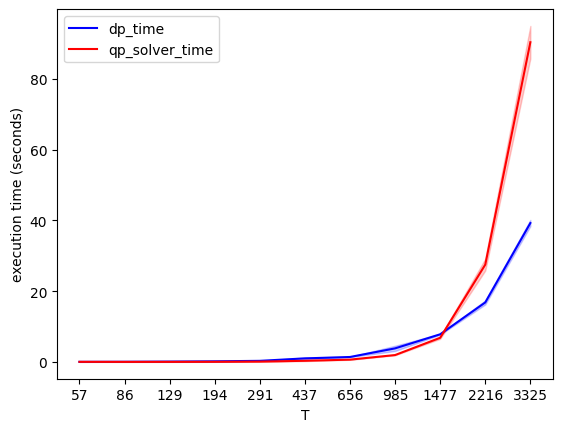

In [ ]:
solvers.options['show_progress'] = False
sys.setrecursionlimit(10000)
verbal=0
plot=0
cnt=0
num_testcases=5
pow1=10
pow2=18
base=1.5
for cvopt in [0,1]:
  if cvopt==0:
    pow1=10
    pow2=21
  else:
    pow1=10
    pow2=21
  qp_avg_times=[]
  dp_avg_times=[]
  qp_std_times=[]
  dp_std_times=[]
  for T in [ int((base)**j) for j in range(pow1,pow2) ]:
    qp_times=[]
    dp_times=[]
    for testcase in range(num_testcases):
      seed(1)
      E=1000
      prices = np.random.uniform(1,1000,T)
      n_cars=2000
      upper_bound=np.zeros(T+1)
      lower_bound=np.zeros(T+1)
      for c in range(n_cars):
          arival = randint(0, T-10)
          duration = randint(8, T-arival-2)
          departure = arival+duration
          demand=randint(1, E)
          rate = randint(math.ceil(demand/duration)+1, 50*math.ceil(demand/duration))
          rapid_charging=np.linspace(0, demand, math.ceil(demand/rate))
          max_curve=np.concatenate([np.zeros(arival),rapid_charging,np.full(T-math.ceil(demand/rate)-arival+3,demand)])
          min_curve=np.concatenate([np.zeros(departure-math.ceil(demand/rate)),rapid_charging,np.full(T-departure+3,demand)])
          upper_bound+=max_curve[:T+1]
          lower_bound+=min_curve[:T+1]

      start = time.time()
      Q = 2*np.diag(prices)
      p = np.zeros(T)
      G = np.concatenate([np.tri(T, T, 0),-1*np.tri(T, T, 0)])
      h = np.concatenate([upper_bound[1:],-1*lower_bound[1:]])
      if cvopt:
          Q=matrix(Q)
          p=matrix(p)
          G=matrix(G)
          h=matrix(h)
          sl=solvers.qp(Q, p, G, h)
          sol=np.array(sl['x']).flatten()
          qp_cost=sl['primal objective']
      else:
          x = cp.Variable(T)
          prob = cp.Problem(cp.Minimize(cp.quad_form(x, Q)),
                          [G @ x <= h])
          prob.solve()
          sol=x.value
          qp_cost=prob.value

      opt=np.concatenate([np.array([0]),sol])
      sums_opt=list(itertools.accumulate(opt))
      if plot:
          plt.plot(upper_bound)
          plt.plot(lower_bound)
          plt.plot(sums_opt)
          plt.show()

      if verbal:
          print(qp_cost)
      qp_cost=np.dot(prices,np.square(sol))
      if verbal:
          print(qp_cost)

      end = time.time()
      qp_times.append(end - start)


      start = time.time()

      prices_prefix_sum=np.zeros(T+1)
      for i in range(1,T+1):
          prices_prefix_sum[i]=prices_prefix_sum[i-1]+1/prices[i-1]

      mem={}
      eps=-0.001

      if qp_cost!=0:
          dp(0,1)
          if verbal:
              print("dp_cost/qp_cost=",dp(0,1)/qp_cost)
      else:
          dp(0,1)
          if verbal:
              print("qp_cost=0")
      l=[0]
      cur=(0,1)
      nxt=mem[cur][1]
      t=0
      dp_cost=0
      while(1):
          (t,ul)=cur
          (tp,u_l)=nxt
          sp=0
          if ul==1 and u_l==1:
              state=upper_bound[t]
              DE=upper_bound[tp]-state
          elif ul==1 and u_l==0:
              state=upper_bound[t]
              DE=lower_bound[tp]-state
          elif ul==0 and u_l==1:
              state=lower_bound[t]
              DE=upper_bound[tp]-state
          elif ul==0 and u_l==0:
              state=lower_bound[t]
              DE=lower_bound[tp]-state
          for tpp in range(t,tp):
              sp+=1/prices[tpp]
          for tpp in range(t,tp):
              state+=(DE/prices[tpp])/sp
              l.append(state)
              dp_cost+=prices[tpp]*((DE/prices[tpp])/sp)**2

          if t==T-1:
              break
          cur=(tp,u_l)
          nxt=mem[(t,ul)][1]

      end = time.time()
      dp_times.append(end - start)

      if qp_cost!=0:
          if verbal:
              print("dp_cost/qp_cost=",dp_cost/qp_cost)
      else:
          if verbal:
              print("dp_cost=",dp_cost)
      if plot:
          plt.plot(upper_bound)
          plt.plot(lower_bound)
          plt.plot(sums_opt, label = "qp_solver")
          plt.plot(l, label = "dp_T^2")
          plt.legend()
          plt.show()

      cnt+=1
      if abs(dp_cost/qp_cost-1)>0.00001:
          print("inaccurate solution found:abs(dp_cost/qp_cost-1)=",abs(dp_cost/qp_cost-1))
          break
    dp_avg_times.append(sum(dp_times)/num_testcases)
    qp_avg_times.append(sum(qp_times)/num_testcases)
    dp_std_times.append(np.std(dp_times))
    qp_std_times.append(np.std(qp_times))
    print("T=",T)
    print("average dp time=", dp_avg_times[-1])
    print("average qp time=", qp_avg_times[-1])
    print("dp time std=", dp_std_times[-1])
    print("qp time std=", qp_std_times[-1])


  plt.plot(list(range(pow2-pow1)), dp_avg_times, 'b-', label='dp_time')
  plt.fill_between(list(range(pow2-pow1)), np.array(dp_avg_times) - np.array(dp_std_times), np.array(dp_avg_times) + np.array(dp_std_times), color='b', alpha=0.2)
  plt.plot(list(range(pow2-pow1)), qp_avg_times, 'r-', label='qp_solver_time')
  plt.fill_between(list(range(pow2-pow1)), np.array(qp_avg_times) - np.array(qp_std_times), np.array(qp_avg_times) + np.array(qp_std_times), color='r', alpha=0.2)
  plt.xticks(list(range(pow2-pow1)), [ int((base)**j) for j in range(pow1,pow2) ] )
  plt.xlabel("T")
  plt.ylabel("execution time (seconds)")
  plt.legend()
  plt.show()

In [ ]:
def gd(w, U, L, opt_cost):
  eta=0.05/max(w)
  T=len(w)
  z=np.zeros(T)

  sw=0
  for i in range(T):
    sw+=1/w[i]
  x_init=np.zeros(T)
  for i in range(T):
    x_init[i]=U[T-1]/(sw*w[i])
  z=np.tri(T, T)@x_init

  while True:
    grad_z=np.zeros(T)
    grad_z[0]=2*w[0]*z[0] + 2*w[1]*(z[0]-z[1])
    grad_z[T-1]=2*w[T-1]*(z[T-1]-z[T-2])
    for i in range(1,T-1):
      grad_z[i]=2*w[i]*(z[i]-z[i-1]) + 2*w[i+1]*(z[i]-z[i+1])
    z_next=z-eta*grad_z
    for i in range(T):
      if z_next[i]>U[i]:
        z_next[i]=U[i]
      if z_next[i]<L[i]:
        z_next[i]=L[i]
    cost=w[0]*z_next[0]**2
    for i in range(1,T):
      cost+=w[i]*(z_next[i]-z_next[i-1])**2
    if abs(cost-opt_cost)/opt_cost<0.001:
      break
    else:
      z=z_next
  return z

T= 17
average dp time= 0.0013018449147542317
average gd time= 0.00019208590189615885
dp time std= 0.00029991764262431945
gd time std= 4.646709534167553e-05
T= 25
average dp time= 0.002876440684000651
average gd time= 0.0037655035654703775
dp time std= 0.0006381107569138133
gd time std= 0.0029339927470012506
T= 38
average dp time= 0.004878123601277669
average gd time= 0.08471123377482097
dp time std= 7.666367443044859e-05
gd time std= 0.09577886000044729
T= 57
average dp time= 0.011482636133829752
average gd time= 0.13291009267171225
dp time std= 0.0009343361263444966
gd time std= 0.17203683079228674
T= 86
average dp time= 0.0258786678314209
average gd time= 0.8845980962117513
dp time std= 0.0016523928225959954
gd time std= 0.599368802844939
T= 129
average dp time= 0.07398041089375813
average gd time= 3.5139970779418945
dp time std= 0.02933092135047037
gd time std= 1.4053832012488099
T= 194
average dp time= 0.17309355735778809
average gd time= 11.18907904624939
dp time std= 0.0666670388

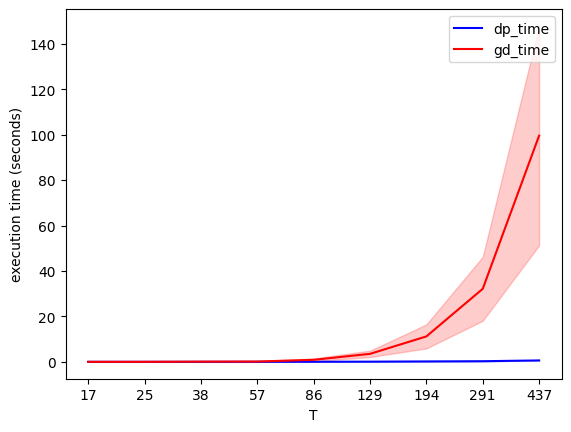

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from random import seed
from random import randint
import math
from cvxopt import matrix, solvers
solvers.options['show_progress'] = True
import itertools
import time
import sys
import cvxpy as cp
import numpy as np

solvers.options['show_progress'] = False
sys.setrecursionlimit(10000)
verbal=0
plot=0
cvopt=0
cnt=0
num_testcases=5
gd_avg_times=[]
dp_avg_times=[]
gd_std_times=[]
dp_std_times=[]
pow1=7
pow2=16
base=1.5
for T in [ int((base)**j) for j in range(pow1,pow2) ]:
  dp_times=[]
  gd_times=[]
  for testcase in range(num_testcases):
    seed(1)
    E=1000
    prices = np.random.uniform(1,10,T)

    n_cars=2000
    upper_bound=np.zeros(T+1)
    lower_bound=np.zeros(T+1)
    for c in range(n_cars):
        arival = randint(0, T-10)
        duration = randint(8, T-arival-2)
        departure = arival+duration
        demand=randint(1, E)
        rate = randint(math.ceil(demand/duration)+1, 50*math.ceil(demand/duration))
        rapid_charging=np.linspace(0, demand, math.ceil(demand/rate))
        max_curve=np.concatenate([np.zeros(arival),rapid_charging,np.full(T-math.ceil(demand/rate)-arival+3,demand)])
        min_curve=np.concatenate([np.zeros(departure-math.ceil(demand/rate)),rapid_charging,np.full(T-departure+3,demand)])
        upper_bound+=max_curve[:T+1]
        lower_bound+=min_curve[:T+1]

    start = time.time()

    prices_prefix_sum=np.zeros(T+1)
    for i in range(1,T+1):
        prices_prefix_sum[i]=prices_prefix_sum[i-1]+1/prices[i-1]

    mem={}
    eps=-0.001
    dp(0,1)
    l=[0]
    cur=(0,1)
    nxt=mem[cur][1]
    t=0
    dp_cost=0
    while(1):
        (t,ul)=cur
        (tp,u_l)=nxt
        sp=0
        if ul==1 and u_l==1:
            state=upper_bound[t]
            DE=upper_bound[tp]-state
        elif ul==1 and u_l==0:
            state=upper_bound[t]
            DE=lower_bound[tp]-state
        elif ul==0 and u_l==1:
            state=lower_bound[t]
            DE=upper_bound[tp]-state
        elif ul==0 and u_l==0:
            state=lower_bound[t]
            DE=lower_bound[tp]-state
        for tpp in range(t,tp):
            sp+=1/prices[tpp]
        for tpp in range(t,tp):
            state+=(DE/prices[tpp])/sp
            l.append(state)
            dp_cost+=prices[tpp]*((DE/prices[tpp])/sp)**2


        if t==T-1:
            break
        cur=(tp,u_l)
        nxt=mem[(t,ul)][1]

    end = time.time()
    dp_times.append(end - start)

    start = time.time()
    z=gd(prices[:-2], upper_bound[1:-2], lower_bound[1:-2], dp_cost)
    end = time.time()
    gd_times.append(end - start)

    if plot:
        plt.plot(upper_bound[:T])
        plt.plot(lower_bound[:T])
        plt.plot([0]+list(z[:T-1]), label = "gd")
        plt.plot(l[:T], label = "dp_T^2")
        plt.legend()
        plt.show()

    cnt+=1

  dp_avg_times.append(sum(dp_times)/num_testcases)
  gd_avg_times.append(sum(gd_times)/num_testcases)
  dp_std_times.append(np.std(dp_times))
  gd_std_times.append(np.std(gd_times))
  print("T=",T)
  print("average dp time=", dp_avg_times[-1])
  print("average gd time=", gd_avg_times[-1])
  print("dp time std=", dp_std_times[-1])
  print("gd time std=", gd_std_times[-1])

plt.plot(list(range(pow2-pow1)), dp_avg_times, 'b-', label='dp_time')
plt.fill_between(list(range(pow2-pow1)), np.array(dp_avg_times) - np.array(dp_std_times), np.array(dp_avg_times) + np.array(dp_std_times), color='b', alpha=0.2)
plt.plot(list(range(pow2-pow1)), gd_avg_times, 'r-', label='gd_time')
plt.fill_between(list(range(pow2-pow1)), np.array(gd_avg_times) - np.array(gd_std_times), np.array(gd_avg_times) + np.array(gd_std_times), color='r', alpha=0.2)
plt.xticks(list(range(pow2-pow1)), [ int((base)**j) for j in range(pow1,pow2) ] )
plt.xlabel("T")
plt.ylabel("execution time (seconds)")
plt.legend()
plt.show()

max price= 10
average dp time= 0.009676086902618408
average gd time= 0.22902673244476318
dp time std= 0.0029402766086603677
gd time std= 0.27943777601976355
max price= 50
average dp time= 0.009187531471252442
average gd time= 0.628285653591156
dp time std= 0.0029613878412785375
gd time std= 0.6093541248491997
max price= 100
average dp time= 0.009133563041687012
average gd time= 0.7175197267532348
dp time std= 0.0031865207150901095
gd time std= 0.7312904119172491
max price= 500
average dp time= 0.009449708461761474
average gd time= 0.9398517537117005
dp time std= 0.0036760483003658523
gd time std= 0.7794841380619647
max price= 1000
average dp time= 0.009176867008209228
average gd time= 0.9915113592147827
dp time std= 0.005729796165732239
gd time std= 0.9805275696230932
max price= 5000
average dp time= 0.008912405967712402
average gd time= 0.9591076874732971
dp time std= 0.0028513548310461806
gd time std= 0.9811985392683217
max price= 10000
average dp time= 0.008936059474945069
average g

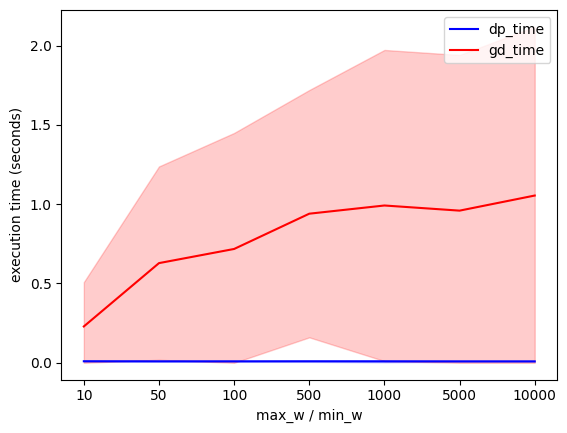

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from random import seed
from random import randint
import math
from cvxopt import matrix, solvers
solvers.options['show_progress'] = True
import itertools
import time
import sys
import cvxpy as cp
import numpy as np

solvers.options['show_progress'] = False
sys.setrecursionlimit(10000)
verbal=0
plot=0
cvopt=0
cnt=0
num_testcases=100
gd_avg_times=[]
dp_avg_times=[]
gd_std_times=[]
dp_std_times=[]
T=50
for max_price in [10,50,100,500,1000,5000,10000]:
  dp_times=[]
  gd_times=[]
  for testcase in range(num_testcases):
    seed(1)
    E=1000
    prices = np.random.uniform(1,max_price,T)

    n_cars=2000
    upper_bound=np.zeros(T+1)
    lower_bound=np.zeros(T+1)
    for c in range(n_cars):
        arival = randint(0, T-10)
        duration = randint(8, T-arival-2)
        departure = arival+duration
        demand=randint(1, E)
        rate = randint(math.ceil(demand/duration)+1, 50*math.ceil(demand/duration))
        rapid_charging=np.linspace(0, demand, math.ceil(demand/rate))
        max_curve=np.concatenate([np.zeros(arival),rapid_charging,np.full(T-math.ceil(demand/rate)-arival+3,demand)])
        min_curve=np.concatenate([np.zeros(departure-math.ceil(demand/rate)),rapid_charging,np.full(T-departure+3,demand)])
        upper_bound+=max_curve[:T+1]
        lower_bound+=min_curve[:T+1]

    start = time.time()

    prices_prefix_sum=np.zeros(T+1)
    for i in range(1,T+1):
        prices_prefix_sum[i]=prices_prefix_sum[i-1]+1/prices[i-1]

    mem={}
    eps=-0.001
    dp(0,1)
    l=[0]
    cur=(0,1)
    nxt=mem[cur][1]
    t=0
    dp_cost=0
    while(1):
        (t,ul)=cur
        (tp,u_l)=nxt
        sp=0
        if ul==1 and u_l==1:
            state=upper_bound[t]
            DE=upper_bound[tp]-state
        elif ul==1 and u_l==0:
            state=upper_bound[t]
            DE=lower_bound[tp]-state
        elif ul==0 and u_l==1:
            state=lower_bound[t]
            DE=upper_bound[tp]-state
        elif ul==0 and u_l==0:
            state=lower_bound[t]
            DE=lower_bound[tp]-state
        for tpp in range(t,tp):
            sp+=1/prices[tpp]
        for tpp in range(t,tp):
            state+=(DE/prices[tpp])/sp
            l.append(state)
            dp_cost+=prices[tpp]*((DE/prices[tpp])/sp)**2


        if t==T-1:
            break
        cur=(tp,u_l)
        nxt=mem[(t,ul)][1]

    end = time.time()
    dp_times.append(end - start)

    start = time.time()
    z=gd(prices[:-2], upper_bound[1:-2], lower_bound[1:-2], dp_cost)
    end = time.time()
    gd_times.append(end - start)

    if plot:
        plt.plot(upper_bound[:T])
        plt.plot(lower_bound[:T])
        plt.plot([0]+list(z[:T-1]), label = "gd")
        plt.plot(l[:T], label = "dp_T^2")
        plt.legend()
        plt.show()

    cnt+=1

  dp_avg_times.append(sum(dp_times)/num_testcases)
  gd_avg_times.append(sum(gd_times)/num_testcases)
  dp_std_times.append(np.std(dp_times))
  gd_std_times.append(np.std(gd_times))
  print("max price=",max_price)
  print("average dp time=", dp_avg_times[-1])
  print("average gd time=", gd_avg_times[-1])
  print("dp time std=", dp_std_times[-1])
  print("gd time std=", gd_std_times[-1])

plt.plot(list(range(7)), dp_avg_times, 'b-', label='dp_time')
plt.fill_between(list(range(7)), np.array(dp_avg_times) - np.array(dp_std_times), np.array(dp_avg_times) + np.array(dp_std_times), color='b', alpha=0.2)
plt.plot(list(range(7)), gd_avg_times, 'r-', label='gd_time')
plt.fill_between(list(range(7)), np.maximum(np.array(gd_avg_times) - np.array(gd_std_times),np.zeros(7)), np.array(gd_avg_times) + np.array(gd_std_times), color='r', alpha=0.2)
plt.xticks(list(range(7)), [10,50,100,500,1000,5000,10000] )
plt.xlabel("max_w / min_w")
plt.ylabel("execution time (seconds)")
plt.legend()
plt.show()